In [23]:
# secure you have the corresponding api keys
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from agents.prepare_tools import available_tools

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )


def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " The User will ask questions, and you should handle them to the best of your ability."
        " You are provided with a list of tool names and their descriptions."
        " For each question, try to identify the most suitable tool that can help solve the task."
        " If you need a tool for the task, give the tool name first with a single sentence like 'Gmail toolkit.', and then make brief explanation."
        " If you don’t need any tool for the task, first reply with 'I don't need a tool for this task.' and then provide your solution."
        " If none of the available tools can help you with the task, reply with 'No tool can solve this task.' first, and then pass the task to the next assistant."
        " Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with 'FINAL ANSWER' so the team knows to stop."
        f"\n{suffix}"
    )

print("Tools are loaded."
      f"{available_tools}")

Tools are loaded.[DuckDuckGoSearchResults(max_results=2, api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))]


In [24]:
from typing import Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
llm1 = ChatOpenAI(model="gpt-4o-mini")
collaborating_agent1 = create_react_agent(
    llm1,
    tools=available_tools,
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

# START->colleague1v->colleague2
def collaborating_node1(
    state: MessagesState,
) -> Command[Literal["colleague2", END]]:
    result = collaborating_agent2.invoke(state)
    goto = get_next_node(result["messages"][-1], "colleague2")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

llm2 = ChatOpenAI(model="gpt-4o-mini")
collaborating_agent2 = create_react_agent(
    llm2,
    tools=available_tools,
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

# colleague2->END
def collaborating_node2(
    state: MessagesState,
) -> Command[Literal[END]]:
    result = collaborating_agent1.invoke(state)
    goto = get_next_node(result["messages"][-1], END)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )
# def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
#     result = chart_agent.invoke(state)
#     goto = get_next_node(result["messages"][-1], "researcher")
#     # wrap in a human message, as not all providers allow
#     # AI message at the last position of the input messages list
#     result["messages"][-1] = HumanMessage(
#         content=result["messages"][-1].content, name="chart_generator"
#     )
#     return Command(
#         update={
#             # share internal message history of chart agent with other agents
#             "messages": result["messages"],
#         },
#         goto=goto,
#     )

In [25]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("colleague1", collaborating_node1)
workflow.add_node("colleague2", collaborating_node2)

workflow.add_edge(START, "colleague1")
graph = workflow.compile()

This is the network graph.


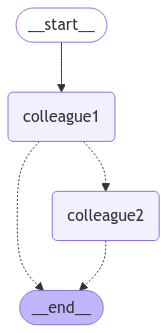

In [26]:
from IPython.display import Image, display

print("This is the network graph.")
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [27]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "How is the weather in WuHan? "
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

{'colleague1': {'messages': [HumanMessage(content='How is the weather in WuHan? ', additional_kwargs={}, response_metadata={}, id='37c4f7e9-f806-4632-82a3-a6eceb0b51fe'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zb0ZTynkcF0hVWl3PUu3HsJb', 'function': {'arguments': '{"query":"current weather in WuHan"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 293, 'total_tokens': 316, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a8d6d379-8c08-4e77-b203-f0734f6a40eb-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'current weather in WuHan'}, 'id': 'ca